<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Binaria_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [109]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import itertools
import matplotlib.pyplot as plt

In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado2/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado2/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Base_CNN/Binarizado2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Se é um cromossomo:
            if predicao[0][0] > predicao[0][1]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict




---



## Implementação



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [116]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 5675 images belonging to 2 classes.
Found 1509 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize



---



### 1 tentativa Precision: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_1'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6548 - acc: 0.6146 - val_loss: 0.6276 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.62755, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 2/50
 - 1s - loss: 0.7229 - acc: 0.5104 - val_loss: 0.6760 - val_acc: 0.5938

Epoch 00002: val_loss did not improve from 0.62755
Epoch 3/50
 - 1s - loss: 0.6503 - acc: 0.6562 - val_loss: 0.6436 - val_acc: 0.6562

Epoch 00003: val_loss did not improve from 0.62755
Epoch 4/50
 - 1s - loss: 0.6294 - acc: 0.6979 - val_loss: 0.6766 - val_acc: 0.6562

Epoch 00004: val_loss did not improve from 0.62755
Epoch 5/50
 - 1s - loss: 0.7032 - acc: 0.5781 - val_loss: 0.6853 - val_acc: 0.5625

Epoch 00005: val_loss did not improve from 0.62755
Epoch 6/50
 - 1s - loss: 0.6765 - acc: 0.6198 - val_loss: 0.6782 - val_acc: 0.5938

Epoch 00006: val_loss did not improve from 0.62755
Epoch 7/50
 - 1s - loss: 0.7096 - acc: 0.5781 - val_loss: 0.6769 - val_acc: 0.6250

Epoch 00007: val_loss did not improv

In [0]:
model.load_weights('drive/My Drive/Resultado/weights_architecture_1.hdf5')

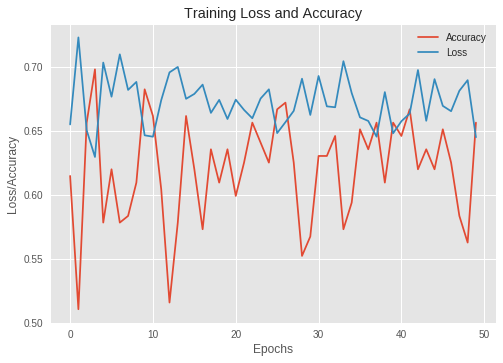

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.64%




---



### 2 tentativa Precision: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_2'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6922 - acc: 0.5990 - val_loss: 0.6913 - val_acc: 0.5781

Epoch 00001: val_loss improved from inf to 0.69133, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6865 - acc: 0.6719 - val_loss: 0.6834 - val_acc: 0.6719

Epoch 00002: val_loss improved from 0.69133 to 0.68344, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6874 - acc: 0.5885 - val_loss: 0.6782 - val_acc: 0.7031

Epoch 00003: val_loss improved from 0.68344 to 0.67820, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6830 - acc: 0.6198 - val_loss: 0.6788 - val_acc: 0.6562

Epoch 00004: val_loss did not improve from 0.67820
Epoch 5/50
 - 1s - loss: 0.6808 - acc: 0.6250 - val_loss: 0.6832 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.67820
Epoch 6/50
 - 1s - loss: 0.6738 - acc: 0.6562 - val_loss: 0.6750 - val_acc: 0.6406

Epoch 00006: val_loss i

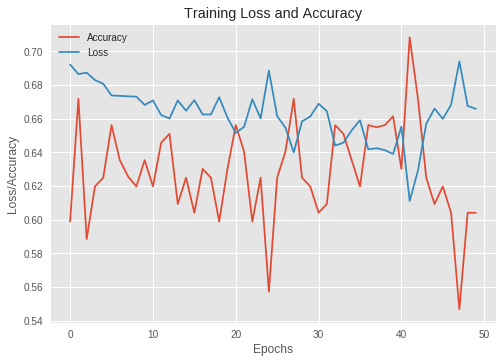

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.64%


### 3 tentativa Precision: 19.10%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_3'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 2.2186 - acc: 0.5964 - val_loss: 0.6182 - val_acc: 0.7656

Epoch 00001: val_loss improved from inf to 0.61823, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 1.4348 - acc: 0.5833 - val_loss: 0.6454 - val_acc: 0.6328

Epoch 00002: val_loss did not improve from 0.61823
Epoch 3/50
 - 1s - loss: 0.9975 - acc: 0.6797 - val_loss: 0.6645 - val_acc: 0.5859

Epoch 00003: val_loss did not improve from 0.61823
Epoch 4/50
 - 1s - loss: 0.7507 - acc: 0.7109 - val_loss: 0.7850 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.61823
Epoch 5/50
 - 1s - loss: 0.7154 - acc: 0.6771 - val_loss: 0.7531 - val_acc: 0.4531

Epoch 00005: val_loss did not improve from 0.61823
Epoch 6/50
 - 1s - loss: 0.5523 - acc: 0.7917 - val_loss: 0.9201 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 0.61823
Epoch 7/50
 - 1s - loss: 0.5539 - acc: 0.7396 - val_loss: 0.6877 - val_acc: 0.6641

Epoch 00007: val_loss did not improv

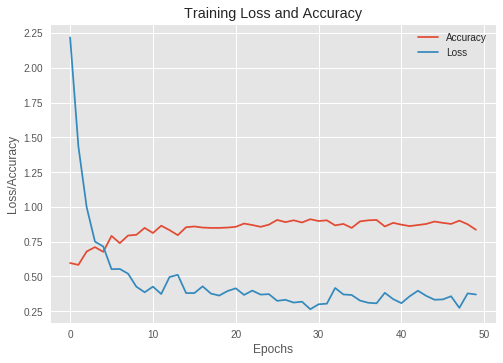

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.10%


### 4 tentativa Precision: 19.65%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_4'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.5060 - acc: 0.7786 - val_loss: 1.1585 - val_acc: 0.5781

Epoch 00001: val_loss improved from inf to 1.15849, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.4034 - acc: 0.8776 - val_loss: 0.9871 - val_acc: 0.5234

Epoch 00002: val_loss improved from 1.15849 to 0.98715, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 3/50
 - 1s - loss: 0.4055 - acc: 0.8698 - val_loss: 0.3995 - val_acc: 0.8514

Epoch 00003: val_loss improved from 0.98715 to 0.39953, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 4/50
 - 1s - loss: 0.2471 - acc: 0.9505 - val_loss: 0.4220 - val_acc: 0.8672

Epoch 00004: val_loss did not improve from 0.39953
Epoch 5/50
 - 1s - loss: 0.3744 - acc: 0.9010 - val_loss: 0.9067 - val_acc: 0.7266

Epoch 00005: val_loss did not improve from 0.39953
Epoch 6/50
 - 1s - loss: 0.3889 - acc: 0.8516 - val_loss: 0.3755 - val_acc: 0.8594

Epoch 00006: val_loss i

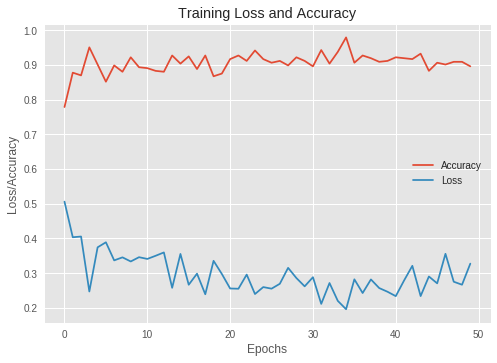

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.65%


### 5 tentativa Precision: 19.63%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_5'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 2.5658 - acc: 0.5052 - val_loss: 0.9890 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 0.98903, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 2/50
 - 1s - loss: 1.2655 - acc: 0.5651 - val_loss: 0.6795 - val_acc: 0.5938

Epoch 00002: val_loss improved from 0.98903 to 0.67954, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 3/50
 - 1s - loss: 1.1245 - acc: 0.5885 - val_loss: 0.6007 - val_acc: 0.7109

Epoch 00003: val_loss improved from 0.67954 to 0.60067, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 4/50
 - 1s - loss: 0.8045 - acc: 0.6617 - val_loss: 0.6336 - val_acc: 0.6562

Epoch 00004: val_loss did not improve from 0.60067
Epoch 5/50
 - 1s - loss: 0.7439 - acc: 0.6667 - val_loss: 0.6079 - val_acc: 0.7344

Epoch 00005: val_loss did not improve from 0.60067
Epoch 6/50
 - 1s - loss: 0.6386 - acc: 0.7396 - val_loss: 0.5185 - val_acc: 0.8359

Epoch 00006: val_loss i

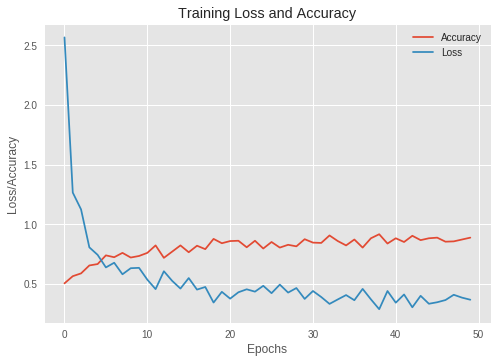

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.63%


### 6 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_6'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.7308 - acc: 0.6354 - val_loss: 1.7829 - val_acc: 0.4766

Epoch 00001: val_loss improved from inf to 1.78295, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 2/50
 - 1s - loss: 0.5896 - acc: 0.7526 - val_loss: 1.2335 - val_acc: 0.6641

Epoch 00002: val_loss improved from 1.78295 to 1.23350, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 3/50
 - 1s - loss: 0.4124 - acc: 0.8516 - val_loss: 1.3325 - val_acc: 0.6328

Epoch 00003: val_loss did not improve from 1.23350
Epoch 4/50
 - 1s - loss: 0.4654 - acc: 0.8333 - val_loss: 0.5790 - val_acc: 0.8125

Epoch 00004: val_loss improved from 1.23350 to 0.57900, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 5/50
 - 1s - loss: 0.4516 - acc: 0.8203 - val_loss: 0.9700 - val_acc: 0.7422

Epoch 00005: val_loss did not improve from 0.57900
Epoch 6/50
 - 1s - loss: 0.4187 - acc: 0.8672 - val_loss: 1.5928 - val_acc: 0.6016

Epoch 00006: val_loss d

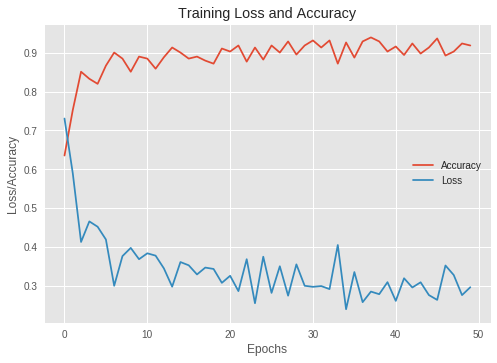

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.64%


### 7 tentativa Precision: 19.67%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_7'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.5861 - acc: 0.7448 - val_loss: 1.5821 - val_acc: 0.4766

Epoch 00001: val_loss improved from inf to 1.58207, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.4513 - acc: 0.8464 - val_loss: 1.0811 - val_acc: 0.6250

Epoch 00002: val_loss improved from 1.58207 to 1.08114, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 3/50
 - 1s - loss: 0.4273 - acc: 0.8516 - val_loss: 0.4524 - val_acc: 0.8438

Epoch 00003: val_loss improved from 1.08114 to 0.45235, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 4/50
 - 1s - loss: 0.3448 - acc: 0.8958 - val_loss: 0.6398 - val_acc: 0.7344

Epoch 00004: val_loss did not improve from 0.45235
Epoch 5/50
 - 1s - loss: 0.3958 - acc: 0.8776 - val_loss: 0.4579 - val_acc: 0.8516

Epoch 00005: val_loss did not improve from 0.45235
Epoch 6/50
 - 1s - loss: 0.3903 - acc: 0.8750 - val_loss: 0.6677 - val_acc: 0.6622

Epoch 00006: val_loss d

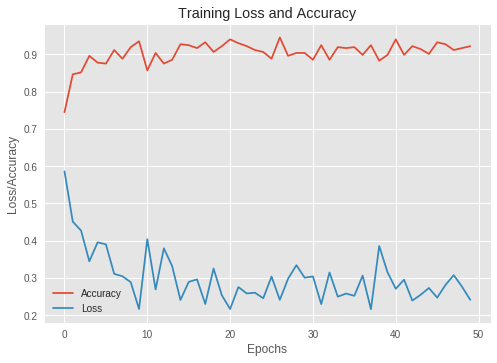

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.67%


### 8 tentativa Precision: 19.46% 

Modelo adaptado do **Lucas Albertins**

*   Função **Adadelta** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_8'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 3.3239 - acc: 0.4687 - val_loss: 0.9781 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.97810, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 1.4210 - acc: 0.6068 - val_loss: 0.6637 - val_acc: 0.6797

Epoch 00002: val_loss improved from 0.97810 to 0.66371, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 3/50
 - 1s - loss: 1.2798 - acc: 0.6016 - val_loss: 1.3570 - val_acc: 0.3906

Epoch 00003: val_loss did not improve from 0.66371
Epoch 4/50
 - 1s - loss: 0.8695 - acc: 0.6719 - val_loss: 0.6053 - val_acc: 0.7031

Epoch 00004: val_loss improved from 0.66371 to 0.60530, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 5/50
 - 1s - loss: 0.9721 - acc: 0.6458 - val_loss: 0.6218 - val_acc: 0.7266

Epoch 00005: val_loss did not improve from 0.60530
Epoch 6/50
 - 1s - loss: 0.7925 - acc: 0.6901 - val_loss: 0.6237 - val_acc: 0.7188

Epoch 00006: val_loss d

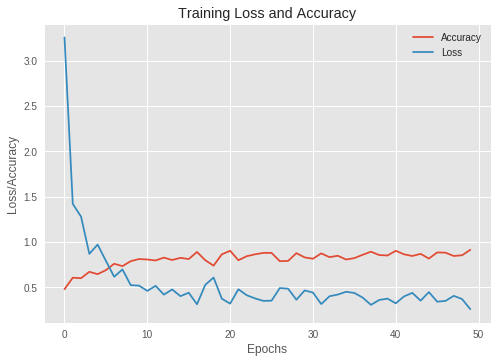

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.46%


### 9 tentativa Precision: 18.62%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_9'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 6.2621 - acc: 0.5260 - val_loss: 3.1540 - val_acc: 0.7344

Epoch 00001: val_loss improved from inf to 3.15397, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 2/50
 - 1s - loss: 4.6515 - acc: 0.6328 - val_loss: 3.1687 - val_acc: 0.5703

Epoch 00002: val_loss did not improve from 3.15397
Epoch 3/50
 - 1s - loss: 1.6842 - acc: 0.5573 - val_loss: 0.6642 - val_acc: 0.7344

Epoch 00003: val_loss improved from 3.15397 to 0.66424, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 4/50
 - 1s - loss: 0.7828 - acc: 0.5885 - val_loss: 0.6693 - val_acc: 0.6797

Epoch 00004: val_loss did not improve from 0.66424
Epoch 5/50
 - 1s - loss: 0.6984 - acc: 0.6354 - val_loss: 0.6815 - val_acc: 0.7031

Epoch 00005: val_loss did not improve from 0.66424
Epoch 6/50
 - 1s - loss: 0.6885 - acc: 0.5990 - val_loss: 0.6714 - val_acc: 0.7578

Epoch 00006: val_loss did not improve from 0.66424
Epoch 7/50
 - 1s - loss: 0.5938 - acc: 0.7188 

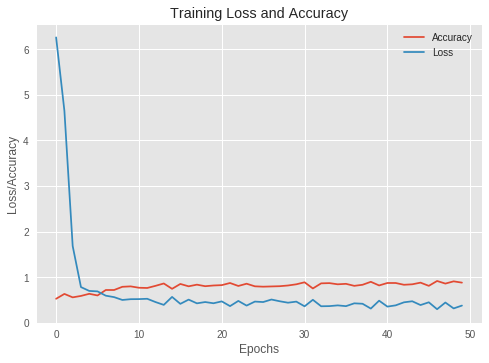

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 18.62%


### 10 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_10'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.7492 - acc: 0.5495 - val_loss: 0.6597 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.65970, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.0735 - acc: 0.6172 - val_loss: 0.8710 - val_acc: 0.5547

Epoch 00002: val_loss did not improve from 0.65970
Epoch 3/50
 - 1s - loss: 1.0488 - acc: 0.6094 - val_loss: 0.9046 - val_acc: 0.3906

Epoch 00003: val_loss did not improve from 0.65970
Epoch 4/50
 - 1s - loss: 0.7166 - acc: 0.6979 - val_loss: 1.0135 - val_acc: 0.4844

Epoch 00004: val_loss did not improve from 0.65970
Epoch 5/50
 - 1s - loss: 0.6306 - acc: 0.7344 - val_loss: 0.9412 - val_acc: 0.3906

Epoch 00005: val_loss did not improve from 0.65970
Epoch 6/50
 - 1s - loss: 0.5290 - acc: 0.7682 - val_loss: 1.0716 - val_acc: 0.3516

Epoch 00006: val_loss did not improve from 0.65970
Epoch 7/50
 - 1s - loss: 0.3880 - acc: 0.8698 - val_loss: 0.6960 - val_acc: 0.6250

Epoch 00007: val_loss did not impro

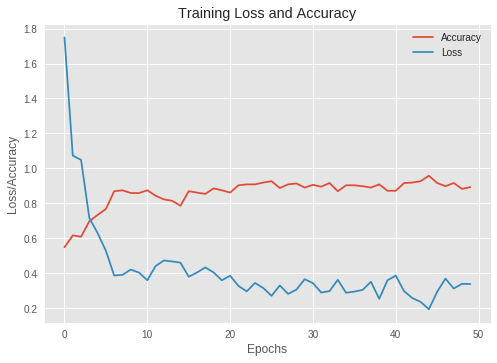

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.64%


### 11 tentativa Precision: 19.58%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_11'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.6530 - acc: 0.6094 - val_loss: 0.8869 - val_acc: 0.6216

Epoch 00001: val_loss improved from inf to 0.88691, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 1.4449 - acc: 0.5938 - val_loss: 0.7646 - val_acc: 0.5781

Epoch 00002: val_loss improved from 0.88691 to 0.76458, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 1.1465 - acc: 0.5964 - val_loss: 0.7964 - val_acc: 0.5391

Epoch 00003: val_loss did not improve from 0.76458
Epoch 4/50
 - 1s - loss: 1.1448 - acc: 0.5781 - val_loss: 0.7279 - val_acc: 0.5156

Epoch 00004: val_loss improved from 0.76458 to 0.72792, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 5/50
 - 1s - loss: 0.9168 - acc: 0.6250 - val_loss: 0.8794 - val_acc: 0.4766

Epoch 00005: val_loss did not improve from 0.72792
Epoch 6/50
 - 1s - loss: 0.8169 - acc: 0.6042 - val_loss: 0.9099 - val_acc: 0.5391

Epoch 00006: val_los

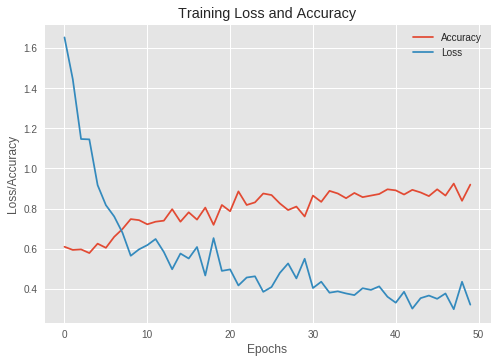

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.58%


### 12 tentativa Precision: 19.64%

Modelo adaptado do **Lucas Albertins**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_12'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.6909 - acc: 0.5052 - val_loss: 0.8028 - val_acc: 0.4766

Epoch 00001: val_loss improved from inf to 0.80285, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 1.1832 - acc: 0.5755 - val_loss: 0.7011 - val_acc: 0.6172

Epoch 00002: val_loss improved from 0.80285 to 0.70112, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 1.0629 - acc: 0.6198 - val_loss: 0.7831 - val_acc: 0.4219

Epoch 00003: val_loss did not improve from 0.70112
Epoch 4/50
 - 1s - loss: 0.9439 - acc: 0.5990 - val_loss: 0.6420 - val_acc: 0.6797

Epoch 00004: val_loss improved from 0.70112 to 0.64199, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 5/50
 - 1s - loss: 0.7203 - acc: 0.6406 - val_loss: 0.6314 - val_acc: 0.6094

Epoch 00005: val_loss improved from 0.64199 to 0.63144, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 6/50
 - 1s - loss: 0.58

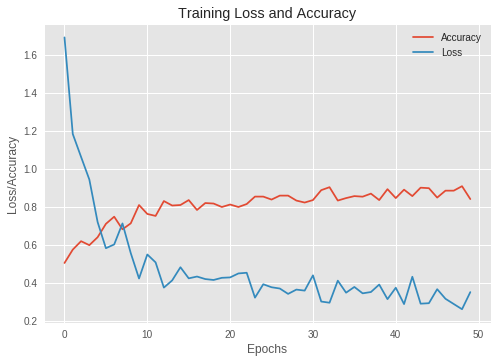

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [0]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.64%


### 13 tentativa Precision: 19.45%

Modelo adaptado do **Lucas Albertins**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_13'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [122]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.1785 - acc: 0.5365 - val_loss: 0.5480 - val_acc: 0.7891

Epoch 00001: val_loss improved from inf to 0.54803, saving model to drive/My Drive/Resultado/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.7457 - acc: 0.6641 - val_loss: 0.3901 - val_acc: 0.8438

Epoch 00002: val_loss improved from 0.54803 to 0.39010, saving model to drive/My Drive/Resultado/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.6859 - acc: 0.6797 - val_loss: 0.4452 - val_acc: 0.8359

Epoch 00003: val_loss did not improve from 0.39010
Epoch 4/50
 - 0s - loss: 0.5139 - acc: 0.7188 - val_loss: 0.2742 - val_acc: 0.8672

Epoch 00004: val_loss improved from 0.39010 to 0.27424, saving model to drive/My Drive/Resultado/weights_architecture_13.hdf5
Epoch 5/50
 - 1s - loss: 0.5853 - acc: 0.7240 - val_loss: 0.4439 - val_acc: 0.8047

Epoch 00005: val_loss did not improve from 0.27424
Epoch 6/50
 - 1s - loss: 0.5183 - acc: 0.7995 - val_loss: 0.3316 - val_acc: 0.8906

Epoch 00006: val_los

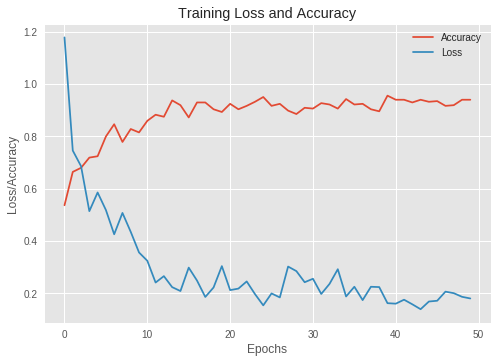

In [123]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [124]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [125]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.45%
